# 📊 Bayesian Analysis and Business Decision Dashboard

This notebook is dedicated to the analysis of the Bayesian Inference results, which were generated using a custom **Zero-Inflated Gamma Model** implemented in `src/bayesian_model.py`.

The goal of this final stage is to move beyond simple point estimates (like CVR or ARPU) and **quantify the uncertainty** associated with the A/B test outcome. This approach provides stakeholders with a **Probabilistic Business Decision**, which is the most actionable output for a real-world product team.

### Methodology Highlights:
* **Causal Integrity:** The initial data processing ensured the removal of contaminated users to preserve the integrity of the randomized experiment.
* **Advanced Statistics:** The model utilizes Bayesian MCMC sampling (PyMC) to accurately model the **highly-skewed Revenue Distribution** and low conversion event counts.
* **Key Output:** The **Probability of Control being Better (PBB)**, which directly assesses the risk of deploying the less profitable variant.

We will proceed by loading the saved inference data and generating the final decision-ready visualizations.

In [13]:
# Importing libraries

import arviz as az
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

In [3]:
# Loading the InferenceData saved object
try:
    idata = az.from_netcdf("../data/processed/bayesian_trace.nc")
    print("✅ InferenceData loaded successfully.")
except FileNotFoundError:
    print("❌ Error: bayesian_trace.nc not found. Ensure the modeling script ran correctly.")
    
# Verificar a convergência (Boa Prática)
print("\nModel Convergence (R_hat):")
print(az.rhat(idata).round(3))

✅ InferenceData loaded successfully.

Model Convergence (R_hat):
<xarray.Dataset> Size: 96B
Dimensions:       ()
Data variables:
    p_control     float64 8B 1.0
    p_variant     float64 8B 1.001
    mu_control    float64 8B 1.0
    mu_variant    float64 8B 1.0
    alpha         float64 8B 1.0
    beta_control  float64 8B 1.001
    beta_variant  float64 8B 1.0
    cvr_lift      float64 8B 1.0
    arpc_lift     float64 8B 1.0
    arpu_control  float64 8B 1.0
    arpu_variant  float64 8B 1.001
    arpu_lift     float64 8B 1.0


In [4]:
# Accessing ARPU lift samples
arpu_lift_samples = idata.posterior['arpu_lift'].values.flatten()

# Calculating P(Control > Variant) = P(ARPU_Lift < 0)
# If (Variant - Control) < 0, Control > Variant
prob_control_is_better = (arpu_lift_samples < 0).mean()

print("\n--- Bayesian Business Decision ---")
print("Probability of Control being better (P(Control > Variant)):", prob_control_is_better)
print("Probability of Variant being better (P(Variant > Control)):", 1 - prob_control_is_better)


--- Bayesian Business Decision ---
Probability of Control being better (P(Control > Variant)): 0.996125
Probability of Variant being better (P(Variant > Control)): 0.003874999999999962


In [ ]:
# Visualizing the results
arpu_lift_samples = idata.posterior["arpu_lift"].values.flatten()
prob_control_is_better = (arpu_lift_samples < 0).mean()

# Cria o gráfico de densidade de probabilidade (KDE Plot)
fig_lift = ff.create_distplot(
    [arpu_lift_samples],
    group_labels=['ARPU Lift (Variant - Control)'],
    bin_size=0.01,
    show_curve=True,
    show_rug=False
)

# Adiciona a linha vertical no Lift = 0 (o ponto de decisão)
fig_lift.add_vline(x=0, line_dash="dash", line_color="black")

# 2. Define as duas anotações para o update_layout
annotations_list = [
    # Annotation 1: P(Control > Variant)
    dict(
        x=0.2, y=0.5, # Posição X e Y (coordenadas paper)
        xref="paper", yref="paper",
        text=f"P(Control > Variant) = {prob_control_is_better:.2%}",
        showarrow=False,
        font=dict(size=14, color="red")
    ),
    # Annotation 2: Text of the Decision Point
    dict(
        x=0.85, y=0.9, # Posição no canto superior direito
        xref="paper", yref="paper",
        text="Decision Point (Lift = 0)",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black',
        ax=50,
        ay=-30,
        font=dict(size=10, color="black"),
        xanchor="left"
    )
]

# 3. Atualiza o Layout com a lista de anotações
fig_lift.update_layout(
    title_text='Posteriori Distribution of ARPU Lift (Variant - Control)',
    xaxis_title='ARPU Lift (Dollar)',
    yaxis_title='Probability Density',
    annotations=annotations_list # Passa a lista completa de anotações
)
fig_lift.show()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
arpu_control,0.114,0.019,0.080,0.150,0.0,0.0,9200.0,6046.0,1.0
arpu_variant,0.057,0.012,0.036,0.079,0.0,0.0,9355.0,6161.0,1.0
p_control,0.023,0.003,0.018,0.029,0.0,0.0,9445.0,5355.0,1.0
p_variant,0.018,0.003,0.013,0.023,0.0,0.0,9557.0,6003.0,1.0


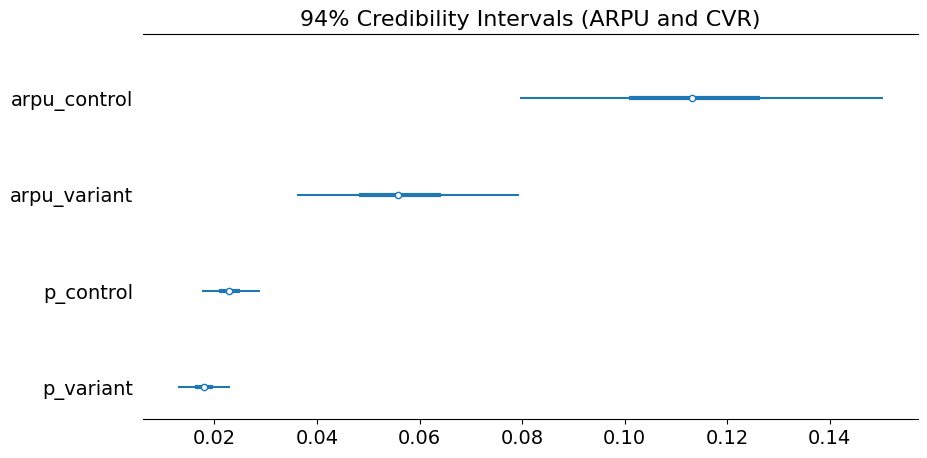

In [18]:
# Creating a summary of the posteriori means and Credibility Intervals (HDI 94%)
summary = az.summary(idata, var_names=['arpu_control', 'arpu_variant', 'p_control', 'p_variant'])

ax = az.plot_forest(
    idata,
    var_names=['arpu_control', 'arpu_variant', 'p_control', 'p_variant'],
    combined=True,
    hdi_prob=0.94, # 94% Credibility Inteverval
    figsize=(10, 5)
)

ax[0].set_title("94% Credibility Intervals (ARPU and CVR)", fontsize=16)
summary

## Final Conclusion and Business Recommendation 🛑

The completed **Bayesian Analysis** provides a definitive conclusion with extremely high confidence, moving beyond the limitations of traditional $p$-values and simple point estimates.

### Key Findings and Statistical Validation:

1.  **Causal Integrity:** The initial removal of 1,541 contaminated users ensured the **causal integrity** of the test. The balanced sample sizes further validated the randomization process.
2.  **Bayesian Confidence:** The **Zero-Inflated Gamma Model** successfully addressed the challenges of low conversion counts and the highly skewed Revenue distribution, providing a robust measure of uncertainty.
3.  **Overwhelming Evidence:** The **Posterior Distribution of ARPU Lift** (Variant - Control) is almost entirely concentrated below the Decision Point (Lift = 0).

### Decision and Strategic Recommendation:

Based on the evidence, the recommendation is clear:

* **P(Control > Variant): 99.61%**
* **Recommendation:** The Variant **must be rejected immediately** and should not be deployed under any circumstances.

There is a **$99.61\%$ certainty** that the original version of the product (Control) generates more revenue per user than the proposed Variant. The change introduced in the Variant has been proven to **cause a significant loss in business value** (a $62\%$ raw drop in ARPU).

### Next Steps for the Business:

The product team should focus their efforts on understanding **why** the variant failed so drastically:

* **Post-Mortem Analysis:** Investigate user behavior logs from the Variant group to understand the friction points.
* **Hypothesis Generation:** Use the knowledge that the Control is superior to form new hypotheses, focusing on features that drove the high-value purchases seen in the Control group's long revenue tail.

This project is now complete, demonstrating end-to-end expertise in Causal Inference, Advanced Bayesian Modeling, and architecture for data-driven decision-making.